In [136]:
#pip install nltk
nltk.download('stopwords')

In [2]:
import requests
from bs4 import BeautifulSoup
from google.cloud import language_v1
import nltk
from nltk.corpus import stopwords
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output, State
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

# Set display row/column to show all data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [148]:
stops = set(stopwords.words('english'))

In [270]:
stops.add('Live')
stops.add('Project')
stops.add('new')
stops.add('example')
stops.add('bank')
stops.add('level')
stops.add('programme')
stops.add('level')

In [275]:
def get_data_from_url(url):
    req = requests.get(url)
    soup = BeautifulSoup(req.text,"html.parser")
    text_elements = soup.find_all("div",{'class':'rich-text'})
    data = ""
    for element in text_elements:
        data = data + element.text
    return data

def get_data_from_store(url=None):
    url = 'https://gee15-22-team5.ew.r.appspot.com/api/text'
    req = requests.get(url)
    content = json.loads(req.content)
    return content

def get_positive_negative_content(sentiment_df):
    positive_text = sentiment_df[sentiment_df['sentiment_category'] == 'positive']['text'].tolist()
    negative_text = sentiment_df[sentiment_df['sentiment_category'] != 'positive']['text'].tolist()
    return positive_text,negative_text

def get_sentiment(content):
    output = []
    content_list = content.split('. ')
    cleansed = list(map(lambda x : re.sub('[^A-Za-z0-9\-]',' ',x),content_list))
    client = language_v1.LanguageServiceClient()
    for record in cleansed:
        rec = {}
        doc = language_v1.types.Document(content = record,language = 'EN',type = 'PLAIN_TEXT')
        request = language_v1.AnalyzeSentimentRequest(document=doc)
        response = client.analyze_sentiment(request=request)
        sentiment = response.document_sentiment.score
        rec['sentiment'] = sentiment
        rec['text'] = record
        sentiment_category = 'neutral'
        if (sentiment >= 0.5):
            sentiment_category = 'positive'
        elif (sentiment < 0.1):
            sentiment_category = 'negative'
        rec['sentiment_category'] = sentiment_category
        output.append(rec)
    return pd.DataFrame.from_records(output)

def get_salient_entities(content_list):
    entities_final_output = {}
    client = language_v1.LanguageServiceClient()
    for item in content_list:
        doc = language_v1.types.Document(content = item,language = 'EN',type = 'PLAIN_TEXT')
        request = language_v1.AnalyzeEntitiesRequest(document=doc)
        # Make the request
        response = client.analyze_entities(request=request)
        for entity in response.entities:
            if (entity.salience > 0.01):
                if entity.name not in stops:
                    entities_final_output[entity.name] = entity.salience
    return entities_final_output

def plot_cloud(word_cloud_dict):    
    plt.figure(figsize=(20, 15))
    plt.axis("off");
    wordcloud = WordCloud( random_state=1,
                     width = 1200, height = 1200,
                      background_color='gold', 
                      colormap='ocean', 
                      collocations=False, 
                      stopwords = stops)
    wordcloud.generate_from_frequencies(frequencies=word_cloud_dict)
    plt.imshow(wordcloud)
    plt.figure()
    plt.show()
    
def plot_cloud_text(pos_content,pos_mask,neg_content, neg_mask):
    fig, axes = plt.subplots(1,2,figsize=(30, 25))
    pos_wordcloud = WordCloud( random_state=1, collocation_threshold = 3,
                      background_color='navy', 
                      colormap='rainbow', 
                      collocations=True, 
                      stopwords = stops,
                      width = 1200, height = 1400,
                      mask=pos_mask).generate(pos_content)
    neg_wordcloud = WordCloud( random_state=1, collocation_threshold = 3,
                      background_color='navy', 
                      colormap='rainbow', 
                      collocations=True, 
                      stopwords = stops, 
                      mask=neg_mask).generate(neg_content)
    axes[0].imshow(pos_wordcloud)
    axes[0].axis('off')
    axes[1].imshow(neg_wordcloud)
    axes[1].axis('off')
    fig.tight_layout()

In [205]:
#content = get_data_from_store()
url = 'https://www.db.com/news/detail/20220914-how-we-live-deutsche-bank-launches-new-programme-for-environmental-impact?language_id=1'
url1 = 'https://www.db.com/news/detail/20220908-deutsche-bank-research-receives-top-rankings-in-institutional-investor-survey?language_id=1'
url2 = 'https://www.db.com/news/detail/20220901-deutsche-bank-india-announces-200-engineering-scholarships-for-women?language_id=1'
content = get_data_from_url(url)
sentiment_df = get_sentiment(content)
positive_text,negative_text = get_positive_negative_content(sentiment_df)

In [206]:
word_cloud_dict = get_salient_entities(negative_text)

In [207]:
pos_mask = np.array(Image.open('upvote.png'))
neg_mask = np.array(Image.open('downvote.png'))

In [208]:
#plot_cloud(word_cloud_dict,neg_mask)

## Sentiments Visualization

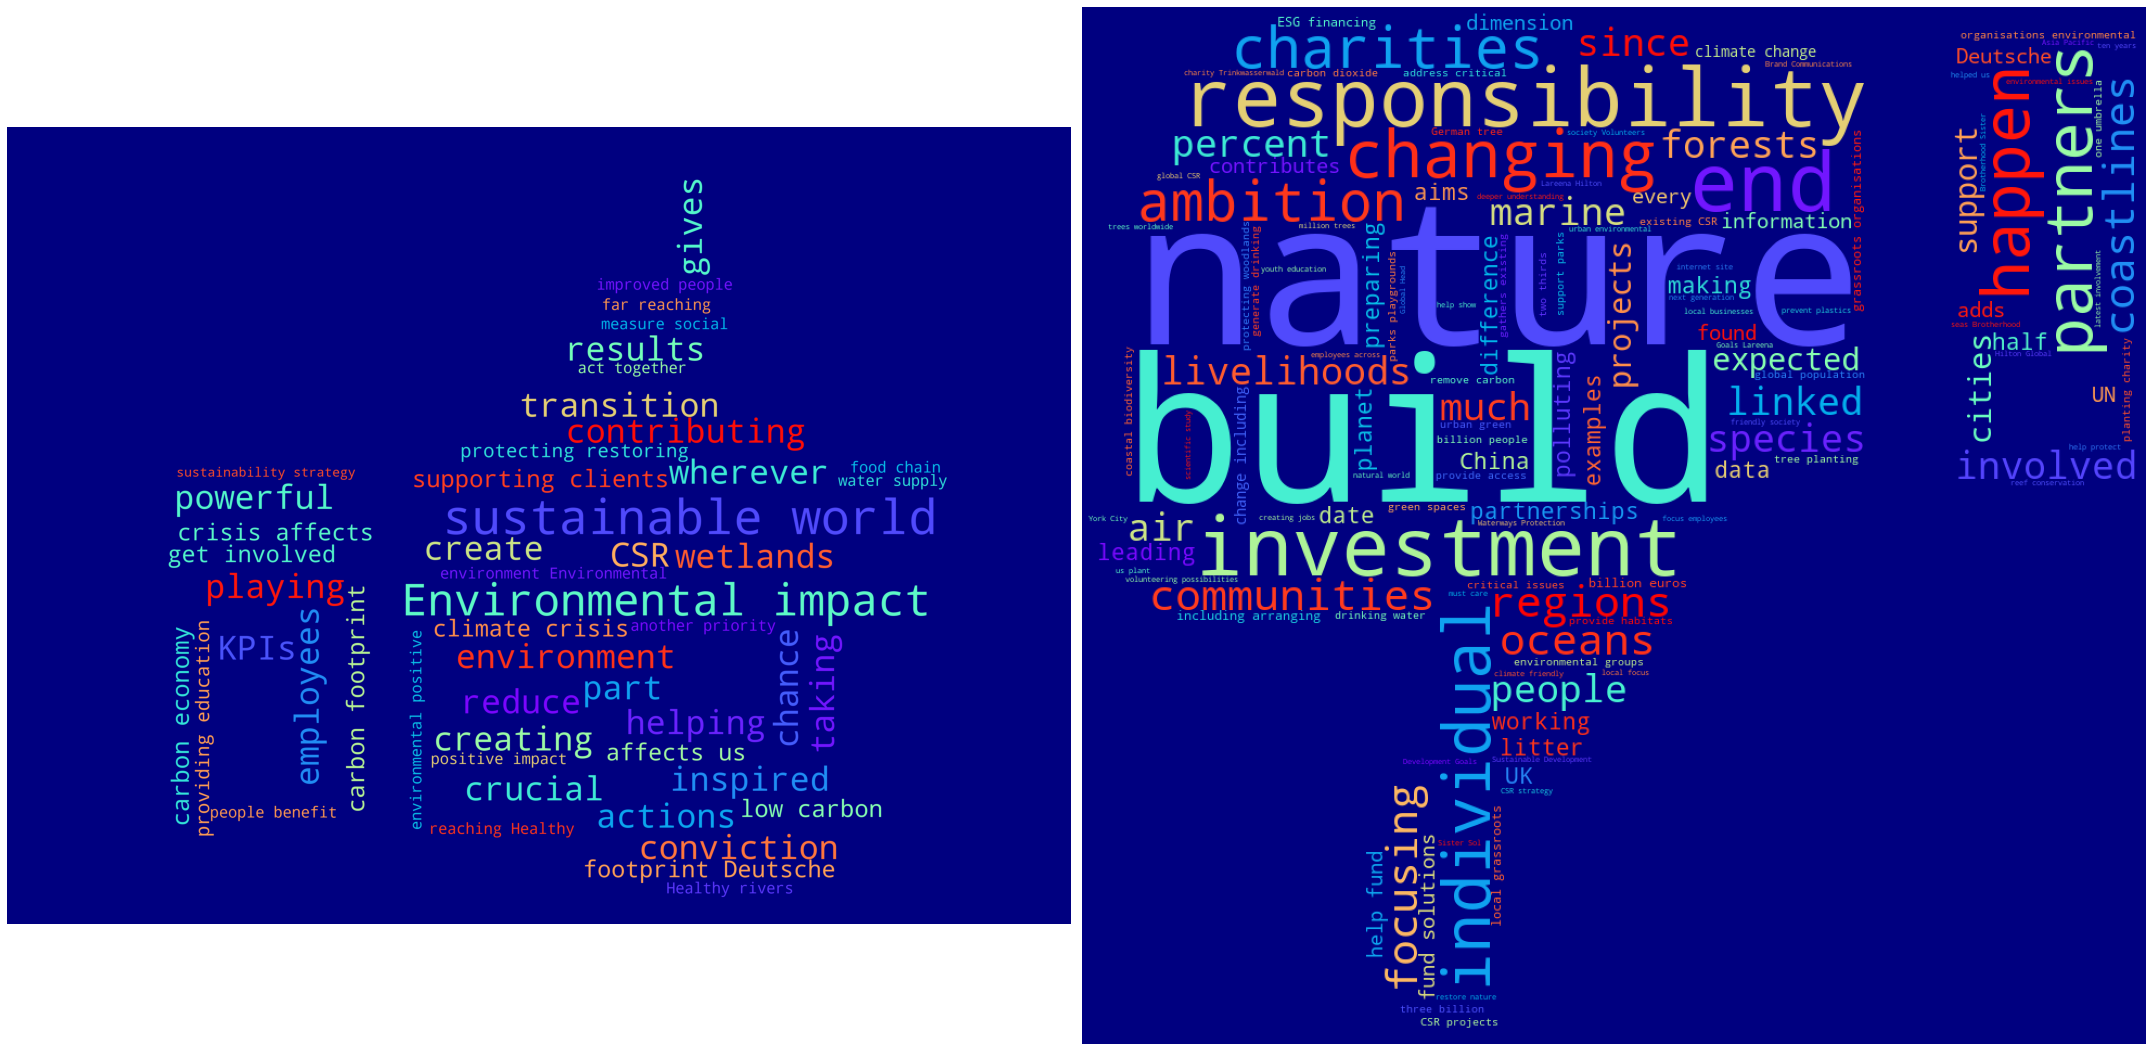

In [274]:
plot_cloud_text(' '.join(positive_text),pos_mask,' '.join(negative_text),neg_mask)

## Get the salient Entities from the media press

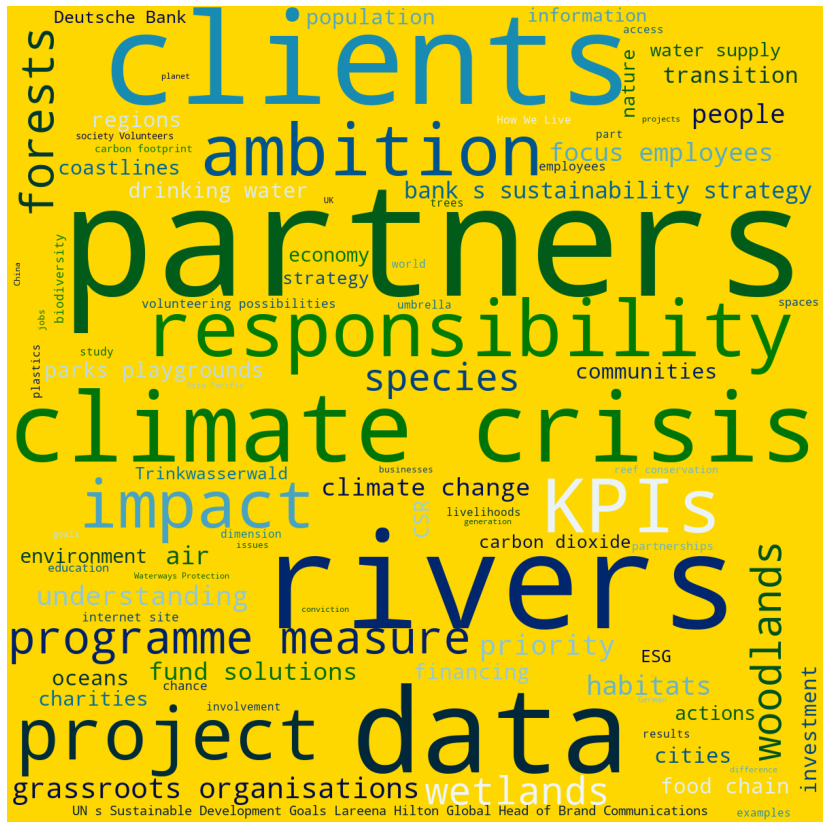

<Figure size 432x288 with 0 Axes>

In [276]:
plot_cloud(get_salient_entities(sentiment_df['text'].tolist()))

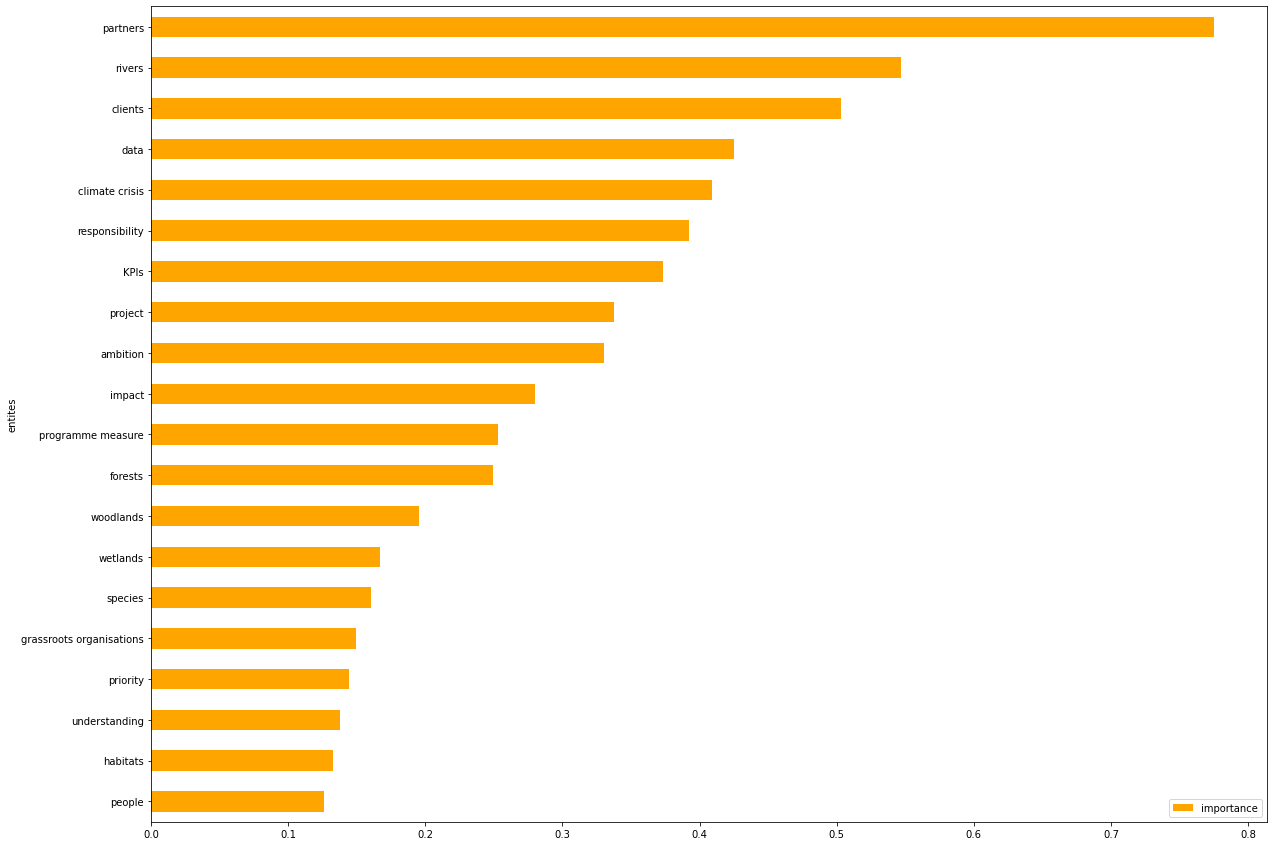

In [328]:
salient_entities = get_salient_entities(sentiment_df['text'].tolist())
salient_entities_df = pd.DataFrame(salient_entities.items(), columns=['entites', 'importance'])
salient_entities_df.sort_values(by=['importance'],ascending=False,inplace=True)
salient_entities_df.head(20).sort_values(by='importance').plot.barh(y='importance',x='entites',color = 'orange',figsize=(20,15))
plt.show()

In [321]:
salient_entities_df.head(10)

,entites,importance
23,partners,0.774976
36,rivers,0.546778
0,clients,0.503354
79,data,0.424877
14,climate crisis,0.408825
8,responsibility,0.392079
77,KPIs,0.373657
52,project,0.337623
26,ambition,0.330528
18,impact,0.280112
